## Классификация текстов: спам-фильтр для SMS

В этом задании вам предстоит взять открытый датасет с SMS-сообщениями, размеченными на спам ("spam") и не спам ("ham"), построить на нем классификатор текстов на эти два класса, оценить его качество с помощью кросс-валидации, протестировать его работу на отдельных примерах, и посмотреть, что будет происходить с качеством, если менять параметры вашей модели.

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [2]:
def write_answer(filename, answer):
    with open(filename, 'w') as fout:
        fout.write(str(answer))
        fout.close()

In [3]:
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None)
data.columns = ['target', 'text']
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


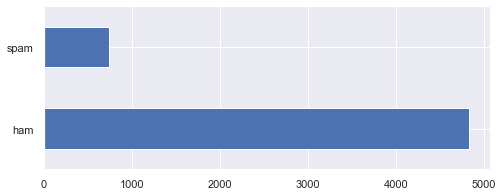

In [4]:
plt.figure(figsize=(8,3))
data.target.value_counts().plot.barh()
plt.show()

#### 1. Подготовьте для дальнейшей работы два списка: список текстов в порядке их следования в датасете и список соответствующих им меток классов. В качестве метки класса используйте 1 для спама и 0 для "не спама".

In [5]:
data.target = data.target.apply(lambda x: 0 if x=='ham' else 1)

corpus = data.text

target = data.target

#### 2. Используя <code>sklearn.feature_extraction.text.CountVectorizer</code> со стандартными настройками, получите из списка текстов матрицу признаков $X$.

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(5572, 8713)

#### 3. Оцените качество классификации текстов с помощью Logistic Regression с параметрами по умолчанию, используя <code>sklearn.cross_validation.cross_val_score</code> и посчитав среднее арифметическое качества на отдельных fold'ах. 

Установите <code>random_state=2</code>. Параметр <code>cv</code> задайте равным 10. В качестве метрики качества используйте f1-меру. Получившееся качество - один из ответов, которые потребуются при сдаче задания. Ответ округлить до 1 знака после запятой.

In [7]:
pipeline = Pipeline([('count_vectorizer', CountVectorizer()), ('logreg', LogisticRegression(random_state=2))])

cv_score_log = cross_val_score(pipeline, corpus, target, scoring='f1', cv=10).mean()

print(f'Logistic Regression Classifier mean F-1 score on 10 folds: {cv_score_log}')
write_answer('submission_1.txt', round(cv_score_log, 1))

Logistic Regression Classifier mean F-1 score on 10 folds: 0.9311542822856882


#### 4. А теперь обучите классификатор на всей выборке и спрогнозируйте с его помощью класс для следующих сообщений:

"FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB"

"FreeMsg: Txt: claim your reward of 3 hours talk time"

"Have you visited the last lecture on physics?"

"Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$"

"Only 99$"

Прогнозы классификатора (0 - не спам, 1 - спам), записанные через пробел, будут ответом в одном из вопросов ниже.

In [8]:
messages = [    
    "FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB",
    "FreeMsg: Txt: claim your reward of 3 hours talk time",
    "Have you visited the last lecture on physics?",
    "Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$",
    "Only 99$"
]

clf = Pipeline([('count_vectorizer', CountVectorizer()), ('logreg', LogisticRegression())])

clf.fit(corpus, target)

clf.predict(messages)

array([1, 1, 0, 0, 0])

In [9]:
write_answer('submission_2.txt', '1 1 0 0 0')

#### 5. Задайте в Count Vectorizer параметр <code>ngram_range=(2,2)</code>, затем <code>ngram_range=(3,3)</code>, затем <code>ngram_range=(1,3)</code>. 

Во всех трех случаях измерьте получившееся в кросс-валидации значение f1-меры, округлите до второго знака после точки, и выпишете результаты через пробел в том же порядке. В данном эксперименте мы пробовали добавлять в признаки n-граммы для разных диапазонов n - только биграммы, только триграммы, и, наконец, все вместе - униграммы, биграммы и триграммы. Обратите внимание, что статистики по биграммам и триграммам намного меньше, поэтому классификатор только на них работает хуже. В то же время это не ухудшает результат сколько-нибудь существенно, если добавлять их вместе с униграммами, т.к. за счет регуляризации линейный классификатор не склонен сильно переобучаться на этих признаках.

In [10]:
%%time

ngrams_range = [(2,2), (3,3), (1,3)]

for n_gram in ngrams_range:
    
    clf_pipeline = Pipeline([('count_vectorizer', CountVectorizer(ngram_range=n_gram)), ('logreg', LogisticRegression())])
    cv_score = cross_val_score(clf_pipeline, corpus, target, scoring='f1', cv=10).mean()

    print(f'F-1 mean score on 10 folds for n_gram range {n_gram}: {cv_score:.2f}')

F-1 mean score on 10 folds for n_gram range (2, 2): 0.82
F-1 mean score on 10 folds for n_gram range (3, 3): 0.72
F-1 mean score on 10 folds for n_gram range (1, 3): 0.92
CPU times: user 56.6 s, sys: 34.8 s, total: 1min 31s
Wall time: 33.3 s


In [11]:
write_answer('submission_3.txt', '0.82 0.72 0.92')

#### 6. Повторите аналогичный п.5 эксперимент, используя вместо логистической регрессии <code>MultinomialNB()</code>. 

Обратите внимание, насколько сильнее (по сравнению с линейным классификатором) наивный Байес страдает от нехватки статистики по биграммам и триграммам.

По какой-то причине обучение наивного байесовского классификатора через Pipeline происходит с ошибкой. Чтобы получить правильный ответ, отдельно посчитайте частоты слов и обучите классификатор. 

In [12]:
%%time

ngrams_range = [(2,2), (3,3), (1,3)]

for n_gram in ngrams_range:
    
    vectorizer = CountVectorizer(ngram_range=n_gram)
    X = vectorizer.fit_transform(corpus)
    
    clf_bayes = MultinomialNB()
    cv_score = cross_val_score(clf_bayes, X, target, scoring='f1', cv=10).mean()

    print(f'Bayes clf F-1 mean score on 10 folds for n_gram range {n_gram}: {cv_score:.2f}')

Bayes clf F-1 mean score on 10 folds for n_gram range (2, 2): 0.65
Bayes clf F-1 mean score on 10 folds for n_gram range (3, 3): 0.38
Bayes clf F-1 mean score on 10 folds for n_gram range (1, 3): 0.89
CPU times: user 1.25 s, sys: 1.1 ms, total: 1.25 s
Wall time: 1.25 s


In [13]:
write_answer('submission_4.txt', '0.65 0.38 0.89')

#### 7. Попробуйте использовать в логистической регрессии в качестве признаков <code>Tf-idf</code> из <code>TfidfVectorizer</code> на униграммах. 

Повысилось или понизилось качество на кросс-валидации по сравнению с <code>CountVectorizer</code> на униграммах? (напишите в файле с ответом 1, если повысилось, -1, если понизилось, и 0, если изменилось не более чем на 0.01). Обратите внимание, что результат перехода к <code>tf-idf</code> не всегда будет таким - если вы наблюдаете какое-то явление на одном датасете, не надо сразу же его обобщать на любые данные.

In [14]:
print('Logistic Regression with CountVectorizer mean F-1 score on 10 folds: 0.931')

pipeline = Pipeline([('tf_idf_vectorizer', TfidfVectorizer()), ('logreg', LogisticRegression())])
cv_score_log = cross_val_score(pipeline, corpus, target, scoring='f1', cv=10).mean()

print(f'Logistic Regression with TfidfVectorizer mean F-1 score on 10 folds: {cv_score_log:.3f}')

Logistic Regression with CountVectorizer mean F-1 score on 10 folds: 0.931
Logistic Regression with TfidfVectorizer mean F-1 score on 10 folds: 0.878


In [15]:
write_answer('submission_5.txt', '-1')